### Import statements

In [2]:
import random 
import math
import matplotlib.pyplot as plt
import time 
import ray
import numpy as np
import imageio
from scipy import optimize

#If it gives an error, ctrl+shift+p - python: select interpreter

In [3]:
#ray.init()

In [4]:
#ray.shutdown()

### Model parameters
Width and height correspond to the boundry of the specimen. Diameter d to the grain size. Set the required void ratio with variable req_void and the tolerance between aggregates with tol. The timeout variable limits the time it spends in the while loop looking for a solution that satisfies req_void > cur_void

In [5]:
width_box = 1.5
height_box = 0.5
d_max = 0.055
d_min = 0.030
tol = 0
requried_void = 0.44
timeout = 120   #[seconds]

r_max = d_max/2
r_min = d_min/2

#### Sieve curve according to Gleisschotter 32/50, class 1 & 2

-> Grain size curves on polybox/papers/SBB
-> Experiment document on polybox -> see dimensions of gpr Model

Have certain sieve categories: for example >80mm, >60mm, >50mm, >40mm, >30mm, <30mm and have procentages according to the mass retained by that sieve. Then, start with the coarsest one and place a random size within its sieve grading in the box until we have reached its procentage. Next, go down and do the same with the smaller aggregates. 

Stop if we have reaches void ratio and report actual procentages and difference to given procentages. Mass = volume so 100% equals 1-req_void.

In [6]:
#Input values: [[mm],lower bound, upper bound]
sieve_63 = np.array([0.063,1,1])
sieve_50 = np.array([0.050,0.7,0.99])    
sieve_40 = np.array([0.040,0.3,0.65])     
sieve_31 = np.array([0.0315,0.01,0.25])
sieve_22 = np.array([0.0224,0.01,0.03])
sieve_low_limit = np.array([0.018,0,0])

grad_curve_bounds = np.vstack([sieve_63,sieve_50,sieve_40,sieve_31,sieve_22,sieve_low_limit])

In [7]:
def pick_rand_curve(grad_curve_bounds):
    #Keep the diameter and initalize matrix
    grad_curve = grad_curve_bounds[:,[0,1]]

    #Use of beta distribution to pick a value between sieve bounds 
    grad_curve[:,1] = np.random.beta(2,2)*(grad_curve_bounds[:,2] - grad_curve_bounds[:,1]) + grad_curve_bounds[:,1]

    return grad_curve

In [8]:
def convert_sieve_curve(grad_curve):
    grad_curve_conv = np.zeros([grad_curve.shape[0]-1,3])
    for i in range(grad_curve.shape[0]-1):
        grad_curve_conv[i] = np.array([grad_curve[i,0]/2,grad_curve[i+1,0]/2,grad_curve[i,1]-grad_curve[i+1,1]])
    return grad_curve_conv


## 2D Circle Random Sequential Adsorption

### Functions

In [9]:
def intersection (r1, cen1, r2, cen2, tol):
    distan = math.sqrt((cen1[0]-cen2[0])**2+(cen1[1]-cen2[1])**2)
    min_Dis = r1+r2+tol

    if distan > min_Dis:
        return False
    else:
        return True   

In [10]:
def any_intersec (cir1, cirList, tol):
    r1 = cir1[2]
    intersec = False
    for cir2 in cirList:
        r2 = cir2[2]
        check = intersection(r1,cir1[0:2],r2,cir2[0:2],tol)
        if check:
            intersec = True
            return intersec
    return intersec

In [11]:
def random_gen (x1,x2):
    value = (x2-x1)*random.random()+x1
    return value

In [12]:
def plot(cirList):
    fig1 = plt.figure()
    for cir in cirList:
        circle1 = plt.Circle((cir[0],cir[1]),cir[2], facecolor='tab:brown',edgecolor='k')
        plt.gcf().gca().add_artist(circle1)
    plt.xlim(0, width_box)
    plt.ylim(0, height_box)
    plt.gca().set_aspect('equal','box')
    plt.show()

In [13]:
def plot_save(cirList,index,filenames):
    fig1 = plt.figure()
    for cir in cirList:
        circle1 = plt.Circle((cir[0],cir[1]),cir[2], facecolor='tab:brown',edgecolor='k')
        plt.gcf().gca().add_artist(circle1)
    plt.xlim(0, width_box)
    plt.ylim(0, height_box)
    plt.gca().set_aspect('equal','box')
    filename = f'images/circle_{index}.png'
    filenames.append(filename)
    plt.savefig(filename,dpi=96)
    plt.close()
    return filenames

In [14]:
# @ray.remote
# def rsa_circle_enhanced():
#     cirList = []
#     cur_void = 1
#     timeout_start = time.time()
#     while req_void < cur_void and time.time() < timeout_start + timeout:
#         r_cur = random_gen(r_min,r_max)
#         x_cur = random_gen(r_cur,width_box-r_cur)
#         z_cur = random_gen(r_cur,height_box-r_cur)
#         new_Circle = [x_cur,z_cur,r_cur]

#         if cirList == []:
#             cirList.append(new_Circle)
#         else:
#             check = any_intersec(new_Circle,cirList,tol)
#             if not check:
#                 cirList.append(new_Circle)
#                 cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
#     elapsed_time = round(time.time()-timeout_start,2)
#     print("Found a solution in ",elapsed_time," seconds")
#     return cirList, cur_void
        

In [15]:
def rsa_circle_normal():
    cirList = []
    cur_void = 1
    timeout_start = time.time()
    while req_void < cur_void and time.time() < timeout_start + timeout:
        r_cur = random_gen(r_min,r_max)
        x_cur = random_gen(r_cur,width_box-r_cur)
        z_cur = random_gen(r_cur,height_box-r_cur)
        new_Circle = [x_cur,z_cur,r_cur]

        if cirList == []:
            cirList.append(new_Circle)
        else:
            check = any_intersec(new_Circle,cirList,tol)
            if not check:
                cirList.append(new_Circle)
                cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
    elapsed_time = round(time.time()-timeout_start,2)
    print("Found a solution in ",elapsed_time," seconds")
    return cirList, cur_void

In [16]:
def rsa_circle_graded(grad_curve, req_void):
    cirList = []
    cur_void = 1
    req_void_cur = 1
    timeout_start = time.time()
    for i,ele in enumerate(grad_curve):
        req_void_cur -= grad_curve[i,2]*(1-req_void)
        print("New iteration:",req_void_cur)
        while req_void_cur < cur_void and time.time() < timeout_start + timeout:
            
            r_cur = random_gen(grad_curve[i,1],grad_curve[i,0])
            x_cur = random_gen(r_cur,width_box-r_cur)
            z_cur = random_gen(r_cur,height_box-r_cur)
            new_Circle = [x_cur,z_cur,r_cur]

            if cirList == []:
                cirList.append(new_Circle)
            else:
                check = any_intersec(new_Circle,cirList,tol)
                if not check:
                    cirList.append(new_Circle)
                    cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
            print(new_Circle[2],cur_void)
    elapsed_time = round(time.time()-timeout_start,2)
    print("Found a solution in ",elapsed_time," seconds")
    return cirList, cur_void

### Main program

In [17]:
# future = rsa_circle_enhanced.remote()
# cirList, cur_void = ray.get(future)
# print("Current void",round(cur_void,4))
# plot(cirList)

# cirList, cur_void = rsa_circle_normal()
# print("Current void",round(cur_void,4))

grad_curve = pick_rand_curve(grad_curve_bounds)
grad_curve_conv = convert_sieve_curve(grad_curve)
print(grad_curve_conv)
cirList, cur_void = rsa_circle_graded(grad_curve_conv, requried_void)
print(cur_void)


[[0.0315     0.025      0.18316796]
 [0.025      0.02       0.37582785]
 [0.02       0.01575    0.3343156 ]
 [0.01575    0.0112     0.0886312 ]
 [0.0112     0.009      0.01805738]]
New iteration: 0.8974259413809476
0.025520845892004033 1
0.025521043058114968 0.9972717419217569
0.026510894084281426 0.9943277449525386
0.025126442676824293 0.9916832020129069
0.03061427897954654 0.9877573250897447
0.028686926120379076 0.9843102032086022
0.02819074565678331 0.980981295645333
0.029231126791441173 0.9774021471045137
0.03100130549899105 0.973376380665969
0.027704136938148563 0.9701614037444143
0.025469898167139116 0.9701614037444143
0.02821744424074224 0.9668261877843727
0.026623480514699458 0.9638571325943104
0.026431325740777167 0.9638571325943104
0.030668707902952834 0.9599172836807748
0.029107317069852635 0.9599172836807748
0.026392529070592863 0.9569995165572831
0.026390085810637218 0.9540822896270847
0.03040449781457185 0.9502100316902702
0.027339997939323738 0.9502100316902702
0.0295242

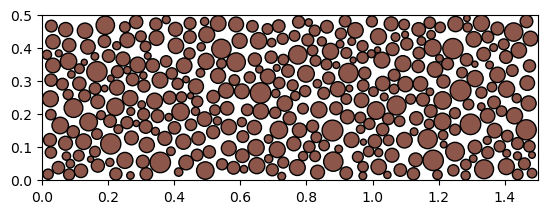

In [18]:
plot(cirList)

## 2D compaction algorithm

### Discretization of simulation domain

In [58]:
def discretization_domain(cirList,h,w,smallest_d,v):

    thickness = smallest_d/2 - 0.001
    num_domains = math.floor(h/thickness)
    max_agg_line = math.floor(w/(smallest_d*(1/(1-v))))
    thickness = round(h/num_domains,3)
    cirList_np = np.array(cirList)

    discret_domains = np.zeros([num_domains,max_agg_line,3]) #3 information per circle (x,y,r)

    for j,t in enumerate(discret_domains):
        condensed_list = cirList_np[np.where((cirList_np[:,1]<=j*thickness+thickness) & (cirList_np[:,1]>=j*thickness))]
        for i,s in enumerate(condensed_list):
            t[i,:]=s 


    return discret_domains, cirList_np, num_domains

### Compaction algorithm


In [52]:
def find_y(cir1, cir2):
    cir1[1] = math.sqrt((cir1[2]+cir2[2])**2 - (cir1[0]-cir2[0])**2) + cir2[1]
    return cir1

In [59]:
def compaction(domain_list, cirList,num_domains):
    #Empty working copy of discrete domains
    comp_circles = np.zeros(cirList.shape)

    #store snapshots of algorithm
    filenames = []

    discret_domain_flattend = np.reshape(domain_list,[num_domains*domain_list.shape[1],domain_list.shape[2]])
    nonzero_domain_flattend = discret_domain_flattend[discret_domain_flattend.any(axis=1)]

    for i in range(domain_list.shape[0]):
        print("iteration ",i)
        domList1 = domain_list[i]
        #All circles in current and below domains, reshaped so it's a vector of all circles
        circles_below = np.reshape(domain_list[0:i+1,:,:],[(i+1)*domain_list.shape[1],domain_list.shape[2]])
        #All circles in current domain, filtered so there are no zeros
        nonzero_cir_cur = domList1[domList1.any(axis=1)]
        num_cir_cur = nonzero_cir_cur.size//3
        #All circles in current domain, filtered so there are no zeros
        nonzero_cir_below = circles_below[circles_below.any(axis=1)]
        num_cir_below = nonzero_cir_below.size//3

        #Working copy of domain
        comp_cir_domain_cur = nonzero_cir_cur

        for idx in range(nonzero_cir_cur.shape[0]):

            cir1 = nonzero_cir_cur[idx]
            #only circles in x distance r_max are relevant and only the ones that are below (y-coordinate)
            relevant_cir_indizes = np.where((nonzero_cir_below[:,0]-cir1[0] <= cir1[2]+nonzero_cir_below[:,2]) & (nonzero_cir_below[:,0]- cir1[0] >= -(cir1[2]+nonzero_cir_below[:,2])) & (nonzero_cir_below[:,1] < cir1[1]))[0]
            proximity_cir_below = nonzero_cir_below[relevant_cir_indizes]
            if proximity_cir_below.size == 0:
                #it's the bottom one, so move it to the bottom
                comp_cir_domain_cur[idx][1] = cir1[2]
            else:
                #check which circle is most relevant, nearest y-coordinate WORNNGNGGG
                #relevant_cir_index = np.abs(proximity_cir_below[:,1]-cir1[1]).argmin()
                #relevant_cir_index = (np.sqrt((proximity_cir_below[:,0]-cir1[0])**2 + (proximity_cir_below[:,1]-cir1[1])**2)-cir1[2]-proximity_cir_below[:,2]).argmin()
                #Move it down so that no collision with circle in lower proximity
                #comp_cir_domain_cur[idx] = find_y(cir1,proximity_cir_below[relevant_cir_index])

                #Find maximum y coordinate (minimum travel distance) to all circles below that are within proximity
                comp_cir_domain_cur[idx,1] = np.amax(np.sqrt((cir1[2]+proximity_cir_below[:,2])**2 - (cir1[0]-proximity_cir_below[:,0])**2) + proximity_cir_below[:,1])
            
        #pass compressed domain into saved state
        domain_list[i,0:num_cir_cur,:] = comp_cir_domain_cur
        comp_circles[num_cir_below-num_cir_cur:num_cir_below,:] = comp_cir_domain_cur
        discret_domain_flattend[num_cir_below-num_cir_cur:num_cir_below,:] = comp_cir_domain_cur
        # filenames = plot_save(discret_domain_flattend,i,filenames)
    
    return comp_circles, filenames
    
        


In [61]:
discret_domains, cirList_np, num_domains = discretization_domain(cirList,height_box,width_box,sieve_low_limit[0],cur_void)
comp_circles, filenames = compaction(discret_domains,cirList_np,num_domains)

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.72544881 0.01212081 0.01180579]
  [0.97080182 0.01340117 0.01165142]
  [1.28167836 0.0144241  0.01381237]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[1.12380537 0.01944338 0.01844713]
  [0.92049686 0.02163406 0.01884955]
  [0.22386789 0.01903683 0.01838332]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[1.25109366 0.47258893 0.02317644]
  [0.53334283 0.47422434 0.02361043]
  [1.05640781 0.47313868 0.02109026]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.91727943 0.48122515 0.01758476]
  [1.46560092 0.48062308 0.01910541]


ValueError: could not broadcast input array from shape (6,3) into shape (0,3)

In [ ]:
# plot(cirList)
# plot(comp_circles)

with imageio.v2.imread(f'Compaction_Algorithm.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

NameError: name 'imageio' is not defined

In [ ]:
def calc_void(cirList,height,width):
    temp_void = 1
    for cir in cirList:
        temp_void = temp_void - math.pi*cir[2]**2/(height*width)
    return temp_void

#new height of the ballast, round up so we include every circle
y_max = math.ceil(np.amax(comp_circles[:,1])*100)/100

new_void = calc_void(comp_circles,y_max,width_box)
print("New void = ",new_void)


New void =  0.3591972151448383
